In [4]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.stats import norm, chi2
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

def BGO_tot(t, tau, QR, RC):        #funzione di fit per bgo non pesata, fit totale
    return QR/tau*(np.exp(-t/tau)-np.exp(-t/(RC)))

#media pesata sugli errori di un array x con errori dx
def w_mean(x,dx):
    return np.sum(x/dx**2)/np.sum(1/dx**2), np.sqrt(1/np.sum(1/dx**2))

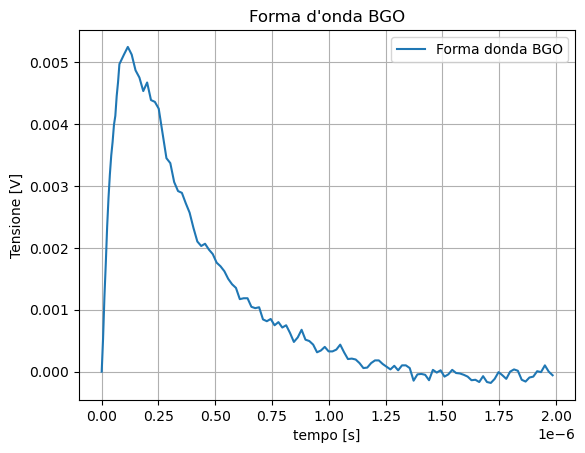

p-value: 1.0
chi-quadro ridotto: 0.04104866075221085
p-value: 1.0
chi-quadro ridotto: 0.042872237915133664
p-value: 1.0
chi-quadro ridotto: 0.04983004690893258


In [5]:
taus = np.zeros(3)
err_taus = np.zeros(3)
RCs = np.zeros(3)
err_RCs = np.zeros(3)
QRs = np.zeros(3)
err_QRs = np.zeros(3)

plt.plot(time, volt, label='Forma donda BGO')
plt.xlabel('tempo [s]')
plt.ylabel('Tensione [V]')
plt.title('Forma d\'onda BGO') 
plt.legend()
plt.grid()
plt.show()

for i in range(0, 3):
    #FORMA D'ONDA BGO

    data = pd.read_csv('Forma-BGO.CSV', delimiter=',')
    data1= pd.read_csv('BGO-Salita.CSV', delimiter=',')
    data2= pd.read_csv('BGO-Discesa.CSV', delimiter=',')

    #combina data1 e data2 in un unico dataframe

    smooth1=2+i
    smooth2=40+i

    times=np.array(data1['Time']+9.7e-08)[::smooth1]
    timed=np.array(data2['Time']+9.7e-08)[::smooth2]
    volts = np.array(data1['AverageVoltage']-0.0006618181818181819)[::smooth1]
    voltd = np.array(data2['AverageVoltage']-0.0006618181818181819)[::smooth2]
    time = np.concatenate((times,timed))    
    volt = np.concatenate((volts,voltd))

    #err sist sensibilità oscilloscopio
    err_volt_s = np.array(data1['error'])[::smooth1]
    err_volt_d = np.array(data2['error'])[::smooth2]
    err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(11))**2+(0.0005)**2)



    # fit BGO senza pesi totale

    ls = LeastSquares(time, volt, err_volt, BGO_tot)
    m1 = Minuit(ls, tau=0.3e-6, QR=10000, RC=1e-7)
    m1.migrad()
    m1.hesse()

    # Calcolo del numero di gradi di libertà (ndof)
    ndof = len(volt) - 1

    # Calcolo del p-value utilizzando la distribuzione chi-quadro
    p_value = (1. - chi2.cdf(m1.fval, df=ndof))

    # Calcolo del chi-quadro ridotto
    chi_reduced = m1.fval / ndof

    print(f"p-value: {p_value}")
    print(f"chi-quadro ridotto: {chi_reduced}")
    taus[i]=m1.values[0]
    err_taus[i] = m1.errors[0]
    RCs[i]=m1.values[2]
    err_RCs[i] = m1.errors[2]
    QRs[i]=m1.values[1]
    err_QRs[i] = m1.errors[1]

#plot di uno dei fit




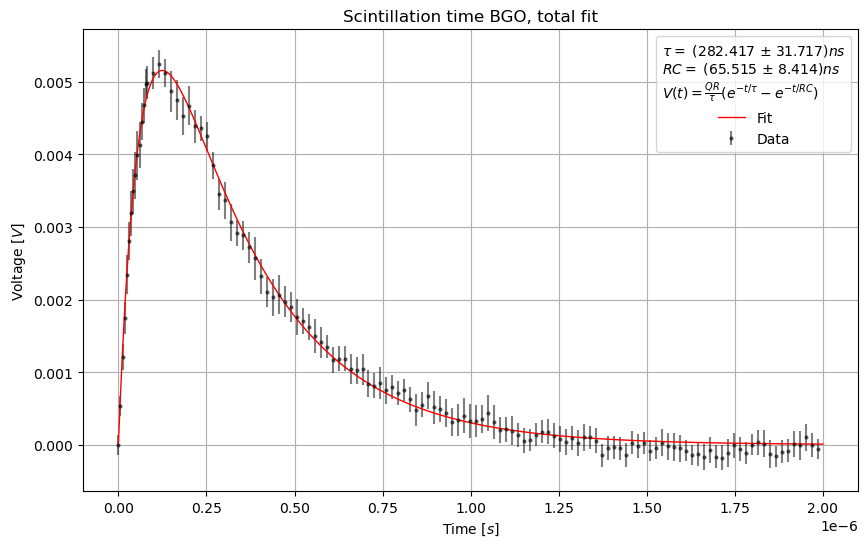

2.819785028766678e-07 1.8767406211353897e-08


In [6]:

#plot finale

smooth1=6
smooth2=17

times=np.array(data1['Time']+9.7e-08)[::smooth1]
timed=np.array(data2['Time']+9.7e-08)[::smooth2]
volts = np.array(data1['AverageVoltage']-0.0006618181818181819)[::smooth1]
voltd = np.array(data2['AverageVoltage']-0.0006618181818181819)[::smooth2]
time = np.concatenate((times,timed))    
volt = np.concatenate((volts,voltd))

#err sist sensibilità oscilloscopio
err_volt_s = np.array(data1['error'])[::smooth1]
err_volt_d = np.array(data2['error'])[::smooth2]
err_volt = np.sqrt((np.concatenate((err_volt_s,err_volt_d))/np.sqrt(6))**2+(0.00012)**2)

#media pesata di tau
tau_mean, err_tau_mean = w_mean(taus, err_taus)
RC_mean, err_RC_mean = w_mean(RCs, err_RCs)
QR_mean, err_QR_mean = w_mean(QRs, err_QRs)

#errore totale
tot_err=np.sqrt(err_tau_mean**2+(np.max(taus)-np.min(taus[0]))**2)

x_axis = np.linspace(0, 2e-6, 10000)
y = BGO_tot(x_axis, taus[0], QRs[0], RCs[0])
plt.subplots(figsize=(10, 6))
plt.errorbar(time, volt, err_volt, fmt='o', label='Data', markersize=2, alpha=0.5, color='black')
plt.plot(x_axis, y, color='red', label='Fit', linewidth=1)
fit_info = []

fit_info.append(f'$\\tau = $ ({taus[0]*1000000000:.3f} $\\pm$ {err_taus[0]*1000000000:.3f})' + '$ns$')
fit_info.append(f'$RC = $ ({RCs[0]*1000000000:.3f} $\\pm$ {err_RCs[0]*1000000000:.3f})' + '$ns$')
fit_info.append('$V(t) = \\frac{QR}{\\tau}(e^{-t/\\tau}-e^{-t/RC})$')
plt.legend(title="\n".join(fit_info), frameon=True)
plt.title('Scintillation time BGO, total fit')
plt.grid(True)
plt.xlabel('Time $[s]$')
plt.ylabel('Voltage $[V]$')
plt.show()

print(tau_mean, err_tau_mean)
